# New baseline with 12?

In [53]:
from pathlib import Path
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Had to add this stuff to get notebook to find files, because it is not
# located in the root folder
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import load_img, img_to_array
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import image_dataset_from_directory

# from bee_tector.config import (
#     FULL_DATA_DIR,
#     IMAGE_SIZE,
#     CURATED_DATA_DIR,
#     MODELS_DIR
# )
# from bee_tector.plots import plot_history
# from bee_tector.data import (
#     load_datasets,
#     undersample_dataset,
#     load_selected_classes
# )
DATASET_PATH = "/kaggle/input/beeszz"
FULL_DATA_DIR = os.path.join(DATASET_PATH, "bombus12_full")

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32 
SEED = 42

In [54]:
def load_datasets(data_dir=FULL_DATA_DIR):
    """
    Load train, validation, and test datasets from a directory.

    Parameters
    ----------
    data_dir : str, optional
        Path to the dataset root directory. Defaults to FULL_DATA_DIR

    Returns
    -------
    train_ds : tf.data.Dataset
        Training dataset
    val_ds : tf.data.Dataset
        Validation dataset
    test_ds : tf.data.Dataset
        Test dataset
    """
    train_ds = image_dataset_from_directory(
        os.path.join(data_dir, 'train'),
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        color_mode='rgb',
        seed=SEED
    )

    val_ds = image_dataset_from_directory(
        os.path.join(data_dir, 'val'),
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        shuffle=False,
        seed=SEED
    )

    test_ds = image_dataset_from_directory(
        os.path.join(data_dir, 'test'),
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        shuffle=False
    )

    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = load_datasets()

Found 3619 files belonging to 12 classes.
Found 781 files belonging to 12 classes.
Found 781 files belonging to 12 classes.


In [55]:
def ensure_rgb(image, label):
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds = train_ds.map(ensure_rgb)
val_ds = val_ds.map(ensure_rgb)
test_ds = test_ds.map(ensure_rgb)

In [43]:
def model_t(shape=(224, 224, 3), num_classes=12):

    data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
        ], name="data_augmentation")
    
    # loading a pretrainded model tf.keras.applications.EfficientNetB0
    base_model = DenseNet121(
    include_top=False, # Exclude the original ImageNet classification head
    weights='imagenet', # Use pretrained weights from ImageNet
    input_shape=(224, 224, 3))  # Input shape of your images
            
    # this freezes the model to Don't update the weights of the base model during training
    # this way only the newly added layers  will be trained
    base_model.trainable = False

    model = Sequential(name="BeeClassifier")

    model.add(Input(shape=shape))
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255))  # RESCALE!
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

    reg = regularizers.l2(1e-5)
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    

    return model

In [11]:
model = model_t()
model.get_layer('densenet121').trainable = True

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [13]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Watch validation loss
    factor=0.5,              # Reduce LR by half
    patience=3,              # Wait 3 epochs without improvement
    min_lr=1e-6,             # Never go below this
    verbose=1                # Print LR updates
)

In [14]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds,
    callbacks=[es, reduce_lr],
    verbose=1
)

Epoch 1/1000


I0000 00:00:1756979494.833201     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


114/114 ━━━━━━━━━━━━━━━━━━━━ 193s 742ms/step - accuracy: 0.2254 - loss: 2.4481 - val_accuracy: 0.4366 - val_loss: 1.6951 - learning_rate: 1.0000e-04
Epoch 2/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 693ms/step - accuracy: 0.5357 - loss: 1.4536 - val_accuracy: 0.6031 - val_loss: 1.2393 - learning_rate: 1.0000e-04
Epoch 3/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 691ms/step - accuracy: 0.6366 - loss: 1.0994 - val_accuracy: 0.6440 - val_loss: 1.1203 - learning_rate: 1.0000e-04
Epoch 4/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 690ms/step - accuracy: 0.7020 - loss: 0.9325 - val_accuracy: 0.6607 - val_loss: 1.0879 - learning_rate: 1.0000e-04
Epoch 5/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 78s 687ms/step - accuracy: 0.7430 - loss: 0.7909 - val_accuracy: 0.6389 - val_loss: 1.1191 - learning_rate: 1.0000e-04
Epoch 6/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 78s 688ms/step - accuracy: 0.7624 - loss: 0.7061 - val_accuracy: 0.6364 - val_loss: 1.1723 - learning_rate: 1.0000e-04
Epoch 7/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 6

In [15]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.6996 - loss: 1.0253
Validation loss: 1.0196, Validation accuracy: 0.6914
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6953 - loss: 0.9316
Test loss: 0.9106, Test accuracy: 0.7183


In [19]:
model.save("bee_classifier_model_t.keras")

In [36]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


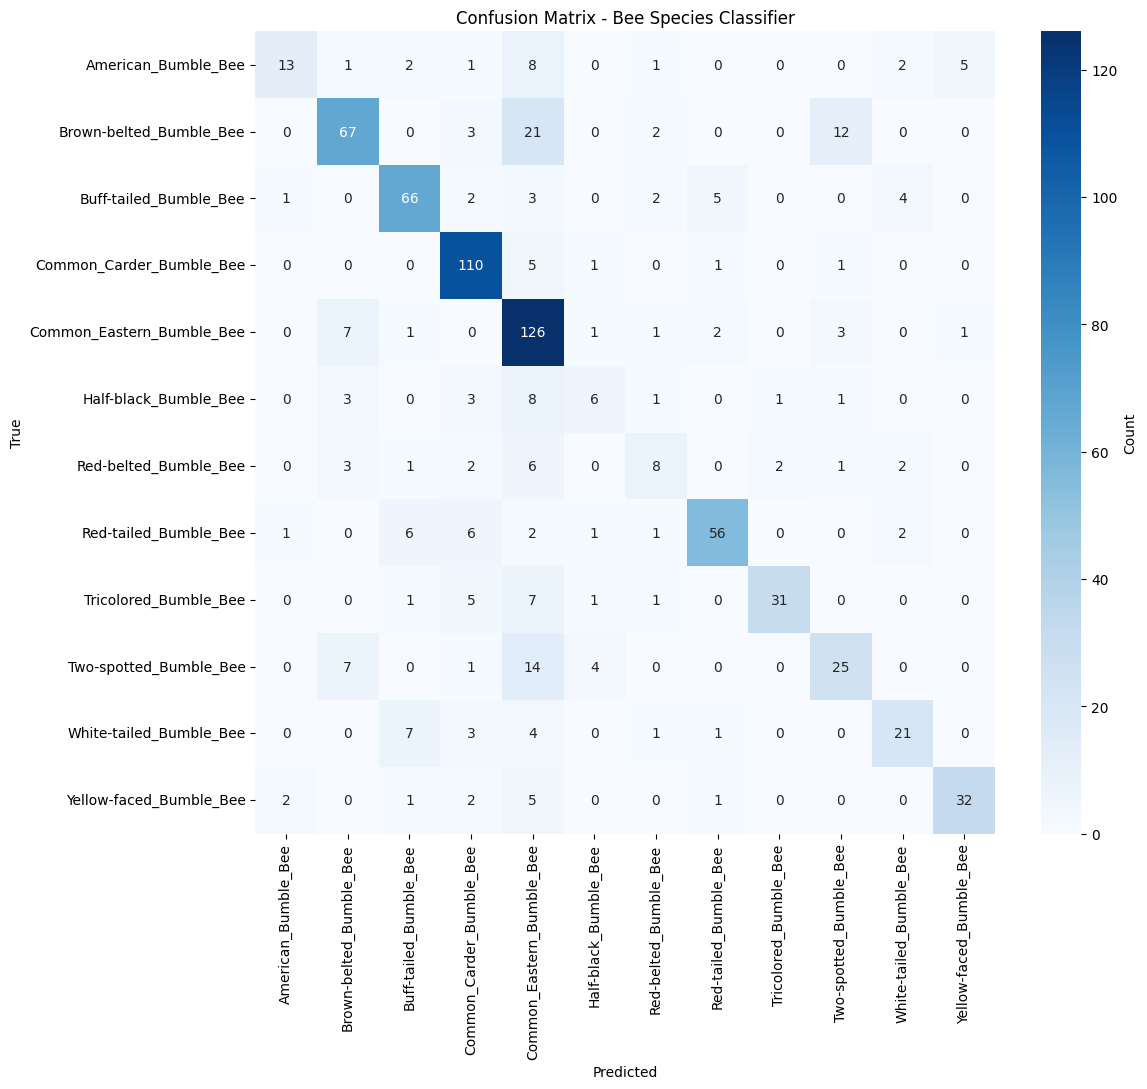

In [39]:
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

plt.figure(figsize=(12,11))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names,
           cbar_kws={'label': 'Count'}) 
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Bee Species Classifier")
plt.tight_layout()
plt.show()

In [56]:
def model_t3(shape=(224, 224, 3), num_classes=12):

    data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3), #increased Contrast
    layers.RandomTranslation(0.1, 0.1)
        ], name="data_augmentation")
    
    # loading a pretrainded model tf.keras.applications.EfficientNetB0
    base_model = DenseNet121(
    include_top=False, # Exclude the original ImageNet classification head
    weights='imagenet', # Use pretrained weights from ImageNet
    input_shape=(224, 224, 3))  # Input shape of your images
            
    # this freezes the model to Don't update the weights of the base model during training
    # this way only the newly added layers  will be trained
    base_model.trainable = False

    model = Sequential(name="BeeClassifier")

    model.add(Input(shape=shape))
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255))  # RESCALE!
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

    reg = regularizers.l2(1e-5)
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    

    return model

In [57]:
model = model_t()
model.get_layer('densenet121').trainable = True

In [59]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [60]:
y_train = []

test_ds = image_dataset_from_directory(
    '/kaggle/input/beeszz/bombus12_full/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

for images, labels in train_ds:
    y_train.extend(labels.numpy())

weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

In [61]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Watch validation loss
    factor=0.5,              # Reduce LR by half
    patience=3,              # Wait 3 epochs without improvement
    min_lr=1e-6,             # Never go below this
    verbose=1                # Print LR updates
)

In [62]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds,
    callbacks=[es, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 181s 739ms/step - accuracy: 0.1548 - loss: 2.5725 - val_accuracy: 0.3457 - val_loss: 1.9141 - learning_rate: 1.0000e-04
Epoch 2/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 690ms/step - accuracy: 0.4142 - loss: 1.7347 - val_accuracy: 0.5429 - val_loss: 1.3626 - learning_rate: 1.0000e-04
Epoch 3/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 78s 689ms/step - accuracy: 0.5367 - loss: 1.3189 - val_accuracy: 0.5583 - val_loss: 1.3418 - learning_rate: 1.0000e-04
Epoch 4/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 689ms/step - accuracy: 0.6282 - loss: 1.0870 - val_accuracy: 0.5915 - val_loss: 1.2199 - learning_rate: 1.0000e-04
Epoch 5/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 690ms/step - accuracy: 0.6863 - loss: 0.9076 - val_accuracy: 0.5685 - val_loss: 1.2685 - learning_rate: 1.0000e-04
Epoch 6/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 693ms/step - accuracy: 0.7144 - loss: 0.8137 - val_accuracy: 0.6197 - val_loss: 1.1501 - learning_rate: 1.0000e-04
Epoch 7/1000
114/114 ━━━━━━━━━━━━

In [63]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7343 - loss: 0.9230
Validation loss: 1.0108, Validation accuracy: 0.7055
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7610 - loss: 0.8031
Test loss: 0.8802, Test accuracy: 0.7478


In [64]:
model.save("bee_classifier_model_t3.keras")

In [67]:
y_true = []
y_pred = []


test_ds = image_dataset_from_directory(
    '/kaggle/input/beeszz/bombus12_full/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)


for images, labels in test_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes)

Found 781 files belonging to 12 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

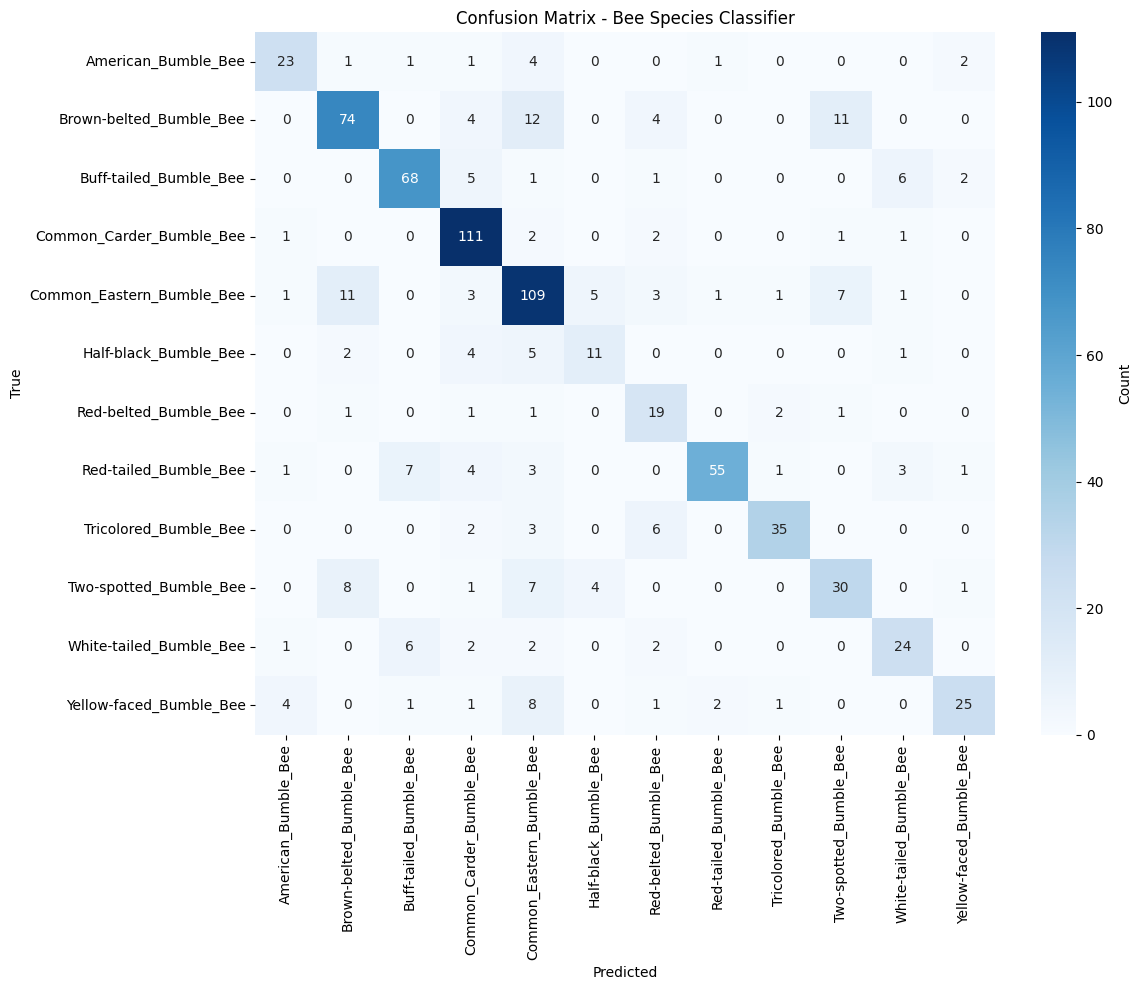

In [69]:
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names,
           cbar_kws={'label': 'Count'}) 
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Bee Species Classifier")
plt.tight_layout()
plt.show()

# 